In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from glob import glob

import mne
import mne_nirs

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..')
from preprocessing.scripts import argParser
from preprocessing.src import Plots

In [4]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/CARE/NIRS_data_clean"
participant_num_len = 5 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

In [5]:
session_dirs = [d for d in glob(study_dir+"/*/V*/*fNIRS") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [15]:
mne.viz.set_3d_backend('pyvista')
raw_intensities = []

for ses in session_dirs[:1]:
    
    raw_intensities.append(mne.io.read_raw_nirx(ses).load_data())
    raw_intensities[-1].resample(0.7) # downsample to 0.7 HZ to run faster
    
#     # replace raw_ints annotations with events from custom file. 
#     # read events from file
#     events, event_dict = mne.read_events(join(ses, "new_eve.txt"))
#     annot_from_events = mne.annotations_from_events(
#         events=events,
#         event_desc=event_dict,
#         sfreq=raw_intensities[-1].info['sfreq'],
#         orig_time=raw_intensities[-1].info['meas_date'])
    
#     raw_intensities[-1].set_annotations(annot_from_events)

Loading /data/perlman/moochie/analysis/CARE/NIRS_data_clean/50502/V0/50502_V0_fNIRS
Reading 0 ... 14350  =      0.000 ...  1836.800 secs...


In [16]:
raw_intensities[0]

<RawNIRX | 50502_V0_fNIRS, 20 x 1286 (1835.7 s), ~232 kB, data loaded>

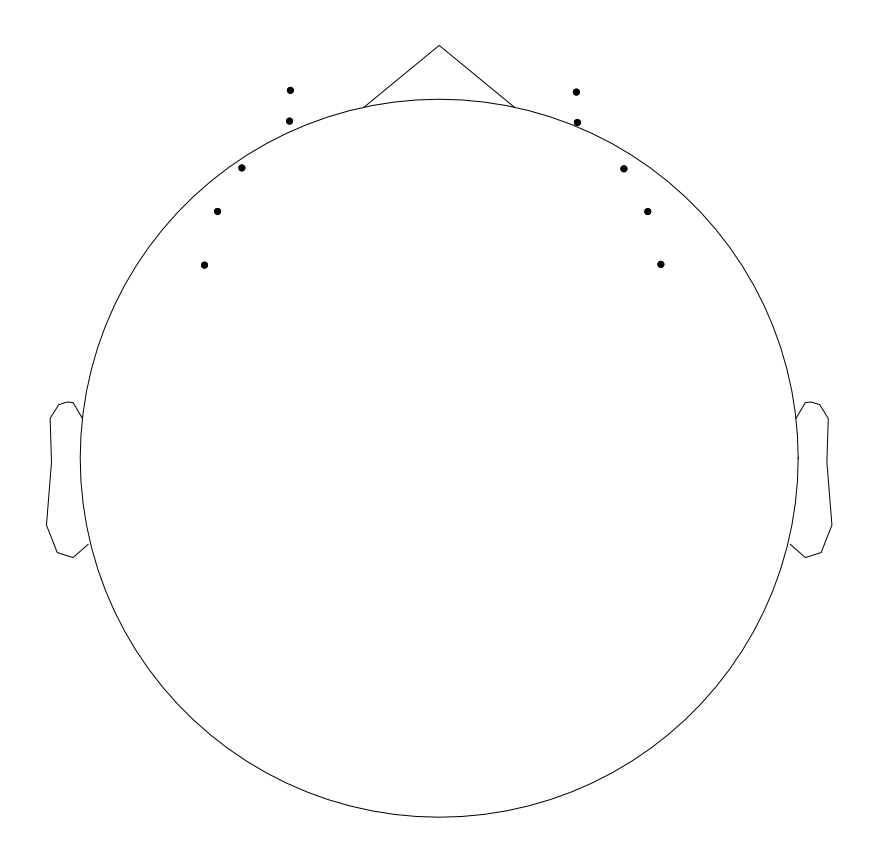

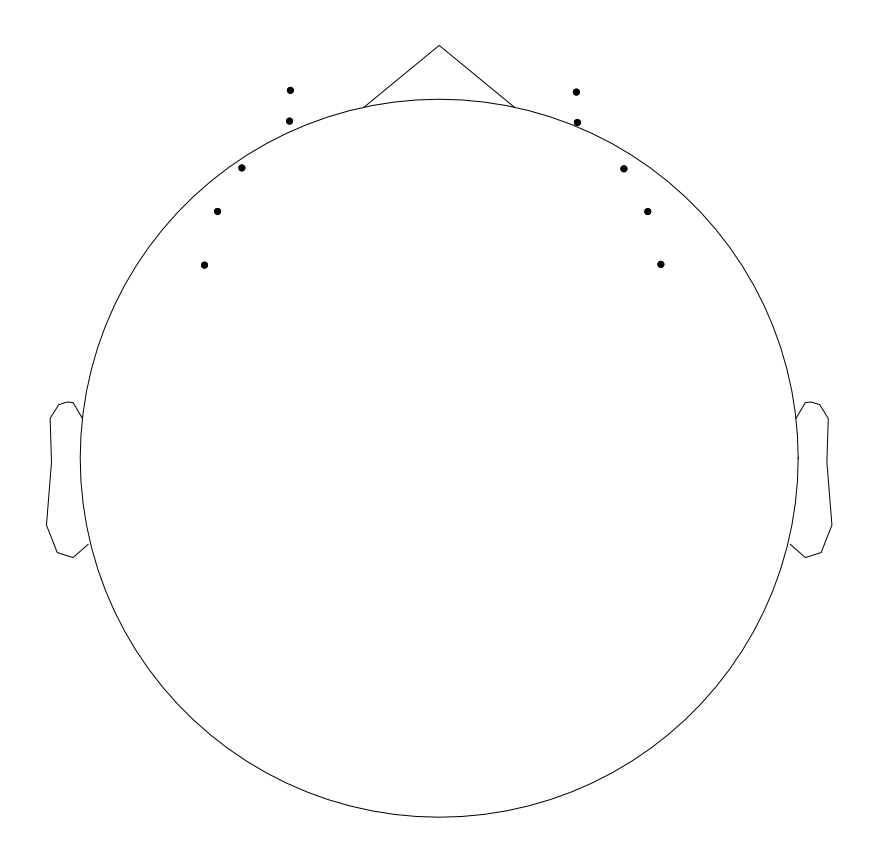

In [17]:
raw_intensities[0].plot_sensors() # viz is screwed up lol

In [9]:
fig = mne.viz.create_3d_figure(size=(800, 600), bgcolor='white')

fig = mne.viz.plot_alignment(
    raw_intensities[0].info,
    show_axes=True,
    subject='fsaverage',
    coord_frame='mri',
    trans='fsaverage',
    surfaces=['brain'],
    fnirs=[
        'channels',
        'pairs',
        'sources',
        'detectors'],
    subjects_dir="/usr/local/pkg/freesurfer/subjects",
    fig=fig)

Channel types::	fnirs_cw_amplitude: 20


In [18]:
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (
    get_long_channels,
    get_short_channels,
    picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix

# Clean up annotations before analysis

Next we update the annotations by assigning names to each trigger ID. Then we crop the recording to the section containing our experimental conditions.

In [19]:
for raw_ints in raw_intensities:
    print(raw_ints)
    print(raw_ints.annotations)
    
    raw_ints.rename({
        '1.0': 'Control',
        '2.0': 'Tapping/Left'})
    
    """ 
    raw_ints.annotations.delete(raw_ints.annotations.description == '15.0')
    
    raw_ints.annotations.set_durations(5)
       
    """

<RawNIRX | 50502_V0_fNIRS, 20 x 1286 (1835.7 s), ~232 kB, data loaded>
<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>


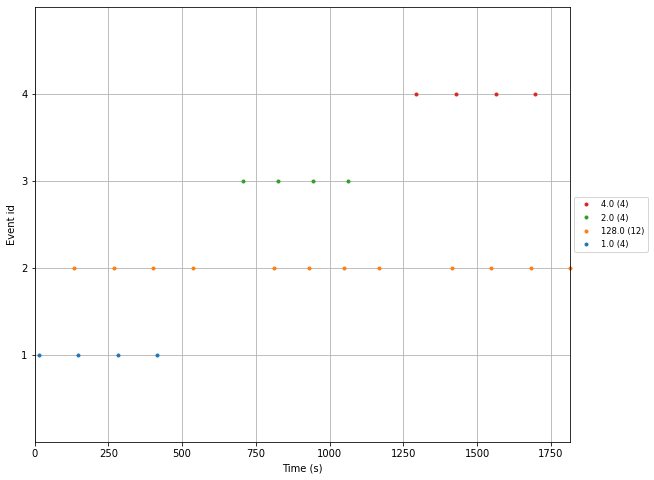

In [20]:
for raw_ints in raw_intensities:
    events, event_dict = mne.events_from_annotations(raw_ints, verbose=False)

    mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_ints.info['sfreq'])

Used Annotations descriptions: ['1.0', '128.0', '2.0', '4.0']


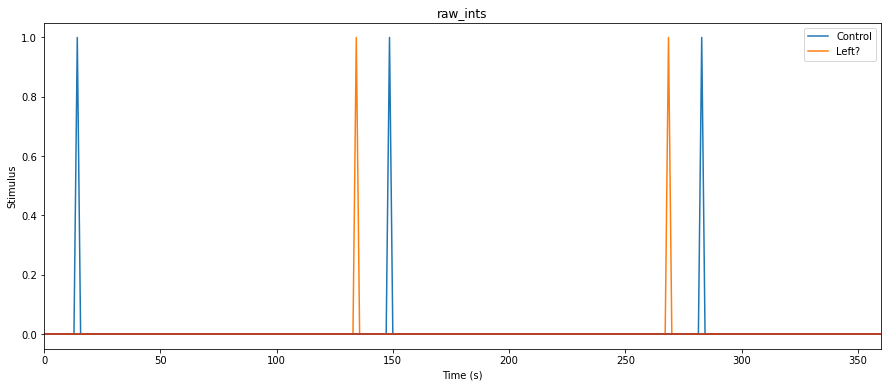

In [21]:
for raw_ints in raw_intensities:
    s = mne_nirs.experimental_design.create_boxcar(raw_ints)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
    plt.plot(raw_ints.times, s, axes=axes)
    plt.legend(["Control", "Left?"], loc="upper right")
    plt.xlabel("Time (s)")
    plt.ylabel("Stimulus")
    plt.title("raw_ints")
    plt.xlim(0, 360)

# Preprocess NIRS Data

In [35]:
raw_ods = []
for raw_ints in raw_intensities:
    raw_od = mne.preprocessing.nirs.optical_density(raw_ints)
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
    
    #short_chs = get_short_channels(raw_haemo)
    long_chs = get_long_channels(raw_haemo)

In [36]:
long_chs

<RawNIRX | 50771_V0_fNIRS, 16 x 1362 (1944.3 s), ~197 kB, data loaded>

# Create design matrix

In [37]:
design_matrix = make_first_level_design_matrix(
    raw_haemo,
    hrf_model='spm',
    stim_dur=5.0,
    drift_order=3,
    drift_model='polynomial')

ValueError: At least one regressor name can't be used as a column identifier: ['10']